## Hidden States 

In [6]:
import torch
# from distilAlhubert.src.upstream.alhubert.expert import UpstreamExpert
# when using in s3prl, you can use 
from s3prl.s3prl.upstream.alhubert.expert import UpstreamExpert
model_ckpt_path = "small.ckpt"
model = UpstreamExpert(model_ckpt_path)
data = [torch.randn(10000) for _ in range(2)] # 16KHz
states = model(data)
print(states["last_hidden_state"].shape) # torch.Tensor: hidden state of the last layer
print(len(states["hidden_states"])) # list[torch.Tensor] hidden states of each layer

# please note that if layer_norm_first=False (default), "hidden_states" will be the outputs of transformer layer 0,1,...11
# layer_norm_first=True (for HuBERT Large teachers), "hidden_states" will be the outputs of the CNN feature estractor and transformer layer 0,1,...10.
# in that case, the output of transformer layer 11 is in states["last_hidden_state"].
# This is because that the feature after layer norm is better for distillation.

c:\Users\YIDAN\Desktop\projects\dysarthria-mtl-steal\venvs3prl\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


torch.Size([2, 31, 768])
12


In [1]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())

if torch.cuda.is_available():
    print("CUDA is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))
    print("CUDA Version (PyTorch compiled):", torch.version.cuda)
    print("CUDA Version (runtime):", torch.cuda.get_device_capability(0))
else:
    print("CUDA not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device : {device}")


2.7.1+cu126
12.6
90701
True
CUDA is available!
GPU Name: NVIDIA GeForce RTX 4060
CUDA Version (PyTorch compiled): 12.6
CUDA Version (runtime): (8, 9)
Device : cuda


## Dataset

In [9]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchaudio  # For loading audio
import os
import librosa

class AudioDataset(Dataset):
    def __init__(self, csv_file, split="train"):
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df['split'] == split].reset_index(drop=True)
        self.sr = 16000

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['path']
        waveform, _ = librosa.load(path, sr=self.sr)
        waveform = torch.tensor(waveform, dtype=torch.float)
        label = torch.tensor(int(row['category']), dtype=torch.float)
        return row['name'], row['path'], waveform, label

def collate_fn(batch):
    names, paths, waveforms, labels = zip(*batch)
    # pad to longest in batch
    max_len = max([x.shape[0] for x in waveforms])
    padded_waveforms = [torch.nn.functional.pad(x, (0, max_len - x.shape[0])) for x in waveforms]
    return names, paths, torch.stack(padded_waveforms), torch.tensor(labels)

## Model

In [10]:
import torch.nn as nn

class AudioClassifier(nn.Module):
    def __init__(self, upstream_model, hidden_dim=768):
        super().__init__()
        self.upstream = upstream_model
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 4)  # 4 levels
        )

    def forward(self, wavs):
        with torch.no_grad():
            states = self.upstream(wavs)
            features = states["last_hidden_state"]  # (B, T, 768)

        x = features.mean(dim=1)  # (B, 768)
        out = self.classifier(x)  # (B, 4)
        return out  # Don't squeeze



## Training Loop

In [11]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for names, paths, wavs, labels in dataloader:
        wavs = wavs.to(device)
        labels = labels.to(device).long()  # important: use long for CrossEntropy

        optimizer.zero_grad()
        outputs = model(wavs)  # shape: [B, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Predictions for multi-class
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy



## Evaluation + Save Predictions to CSV

In [35]:
def evaluate(model, dataloader, device, criterion=None, output_csv=None):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_rows = []

    with torch.no_grad():
        for names, paths, wavs, labels in dataloader:
            wavs = wavs.to(device)
            labels = labels.to(device).long()

            outputs = model(wavs)

            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item()

            # Multi-class predictions
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if output_csv:
                preds_cpu = preds.cpu().tolist()
                for name, path, cat, pred in zip(names, paths, labels.cpu(), preds_cpu):
                    all_rows.append({
                        "name": name,
                        "path": path,
                        "category": int(cat),
                        "predicted_score": int(pred)
                    })

    if output_csv:
        pd.DataFrame(all_rows).to_csv(output_csv, index=False)

    avg_loss = total_loss / len(dataloader) if criterion else None
    accuracy = correct / total
    return avg_loss, accuracy, correct


## Full training Script

c:\Users\YIDAN\Desktop\projects\dysarthria-mtl-steal\venvs3prl\lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 0 | Train Loss: 1.3467 | Val Loss: 1.3289 | Train Acc: 0.3892 | Val Acc: 0.3810
✅ New best model saved at epoch 0
Epoch 1 | Train Loss: 1.2837 | Val Loss: 1.2865 | Train Acc: 0.5616 | Val Acc: 0.4286
✅ New best model saved at epoch 1
Epoch 2 | Train Loss: 1.1853 | Val Loss: 1.2498 | Train Acc: 0.6453 | Val Acc: 0.3333
✅ New best model saved at epoch 2
Epoch 3 | Train Loss: 1.1036 | Val Loss: 1.2247 | Train Acc: 0.7044 | Val Acc: 0.3810
✅ New best model saved at epoch 3
Epoch 4 | Train Loss: 1.0197 | Val Loss: 1.1995 | Train Acc: 0.7389 | Val Acc: 0.3810
✅ New best model saved at epoch 4
Epoch 5 | Train Loss: 0.9485 | Val Loss: 1.1860 | Train Acc: 0.7635 | Val Acc: 0.4286
✅ New best model saved at epoch 5
Epoch 6 | Train Loss: 0.8783 | Val Loss: 1.1829 | Train Acc: 0.8128 | Val Acc: 0.4286
✅ New best model saved at epoch 6
Epoch 7 | Train Loss: 0.8263 | Val Loss: 1.1824 | Train Acc: 0.7586 | Val Acc: 0.4762
✅ New best model saved at epoch 7
Epoch 8 | Train Loss: 0.7720 | Val Loss:

c:\Users\YIDAN\Desktop\projects\dysarthria-mtl-steal\per_patient_accuracy.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


[✓] Saved plot to: multiclass_results_8\patient_accuracy_barplot.png
🧪 Test Loss: 1.2141 | Test Accuracy: 0.4000


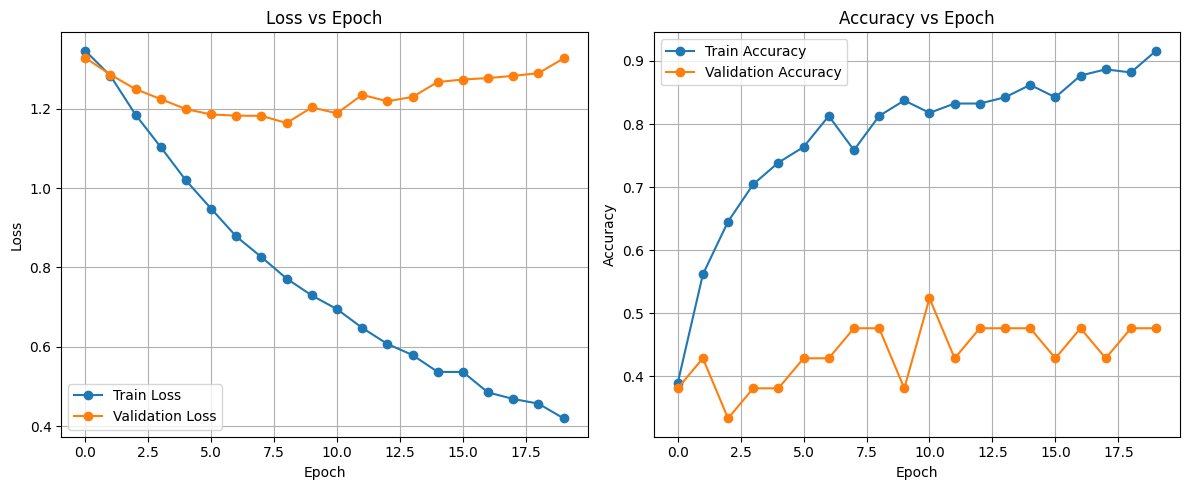

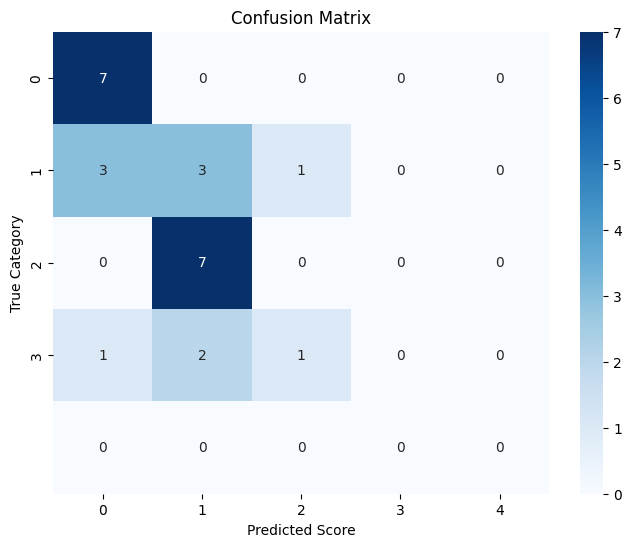

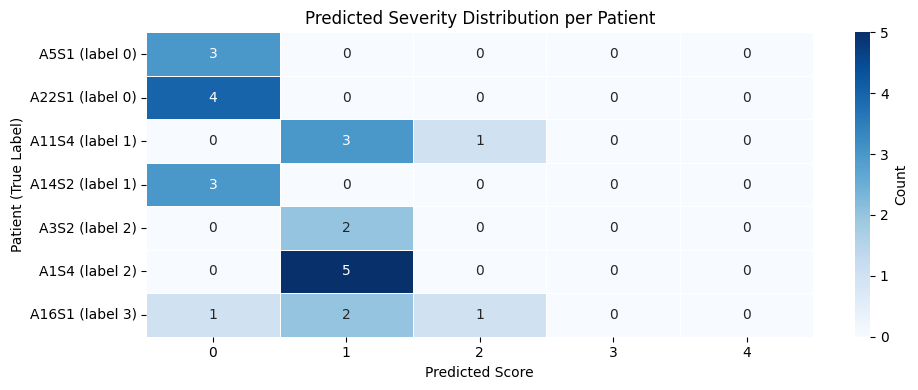

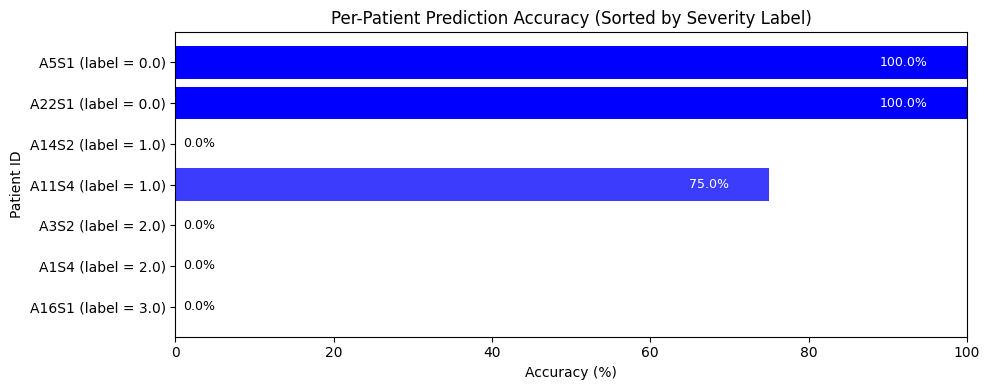

In [39]:
import sys
import os

# Assumes your ****notebook**** is inside "project_root/s3prl_things"
# So we go one level up to reach "project_root"
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

import pandas as pd
from generate_confusion_matrix import plot_confusion_matrix_spice
from generate_curves import generate_curves
from plot_patient_distribution import plot_patient_prediction_matrix
from per_patient_accuracy import plot_patient_accuracies
from collections import Counter
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model once from local ckpt
upstream = UpstreamExpert("small.ckpt")
upstream.to(device)

# 🔁 Toggle this as needed
freeze_upstream = False

for param in upstream.parameters():
    param.requires_grad = not freeze_upstream

model = AudioClassifier(upstream).to(device)

csv_path = r"C:\Users\YIDAN\Desktop\projects\dysarthria\dataset_youtube_splits.csv"

# Create class weights to help with imbalance
df = pd.read_csv(csv_path)
train_labels = df[df["split"] == "train"]["category"].tolist()
label_counts = Counter(train_labels) # Count class frequencies
total = sum(label_counts.values())
class_weights = [total / label_counts[i] for i in sorted(label_counts)] # Compute inverse frequency class weights
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

train_ds = AudioDataset(csv_path, split="train")
val_ds = AudioDataset(csv_path, split="valid")
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=False, collate_fn=collate_fn, pin_memory=True)

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4, weight_decay=1e-5) # L2 Regularization (Weight Decay)
criterion = nn.CrossEntropyLoss(weight=class_weights) # class_weights: torch.tensor([w0, w1, ..., wn]), to help with imbalance

best_val_loss = float("inf")
best_model_path = "best_model.pth"
training_stats = []
total_epochs = 20

for epoch in range(total_epochs):
    train_loss, train_acc = train(model, train_dl, optimizer, criterion, device)
    val_loss, val_acc, _ = evaluate(model, val_dl, device, criterion=criterion)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    training_stats.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
    })

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), best_model_path)
        best_epoch = epoch
        print(f"✅ New best model saved at epoch {epoch}")

# Base folder name to save all results to
base_dir = "multiclass_results"
output_dir = base_dir
i = 1
while os.path.exists(output_dir): # Find an unused directory name
    i += 1
    output_dir = f"{base_dir}_{i}"
os.makedirs(output_dir) # Create the directory

# Save training log
training_log_csv_path = os.path.join(output_dir, "training_log.csv")
df_stats = pd.DataFrame(training_stats)
df_stats.to_csv(training_log_csv_path, index=False)
print(f"✅ Training stats saved to {training_log_csv_path}")

# Final evaluation on test set
test_ds = AudioDataset(csv_path, split="test")
test_dl = DataLoader(test_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)
model.load_state_dict(torch.load(best_model_path)) # Load best model
model.to(device)
test_predictions_csv_path = os.path.join(output_dir, "test_predictions.csv") # Define test_predictions_csv_path
test_loss, test_acc, total_correct = evaluate(model, test_dl, device, criterion=criterion, output_csv=test_predictions_csv_path) # Evaluate
print(f"✅ Test predictions saved to {test_predictions_csv_path}")
# After computing test_loss, total_correct, total_samples, and test_acc
summary_txt_path = os.path.join(output_dir, "test_summary.txt")  
with open(summary_txt_path, "w") as f:
    f.write(f"Total test samples: {len(test_ds)}\n")
    f.write(f"Total test correct: {total_correct}\n")
    f.write(f"Test loss: {test_loss}\n")
    f.write(f"Test accuracy: {test_acc:.4f}\n")
    f.write(f"Total Epochs: {total_epochs}\n")
    f.write(f"Best Val Epoch: {best_epoch}\n")
    f.write(f"Best Val Loss: {best_val_loss}\n")
    f.write(f"Upstream Frozen: {freeze_upstream}\n")

# Print visualisations
generate_curves(training_log_csv_path)
plot_confusion_matrix_spice(test_predictions_csv_path)
plot_patient_prediction_matrix(test_predictions_csv_path)
plot_patient_accuracies(test_predictions_csv_path)

print(f"🧪 Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

